In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # or 'Agg' for headless
import main
import detection
import preprocessing as pp
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import math

# Load Images

image array:
 [[197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 ...
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]]
num images loaded: 10


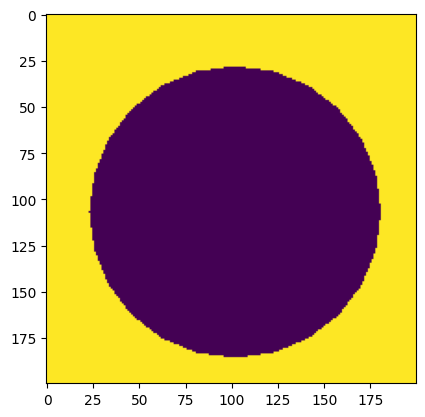

In [2]:
base_path = os.getcwd()

img_path = os.path.join(base_path, "data", "geometric shapes dataset", "Circle", "Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png")

# cv2.imread does not work on linux, im using matlab for visualization
img_BGR = main.load_img(img_path, greyscale=False)
img = main.load_img(img_path)
print("image array:\n", img)
main.plt.imshow(img)

folder_path = os.path.join(base_path, 'data', 'geometric shapes dataset', 'Square')
data = main.load_img_from_folder(folder_path)
print("num images loaded:", len(data))


image shape: (200, 200)
lines detected:
[]


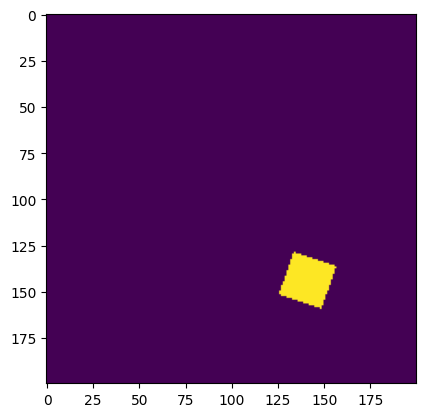

In [3]:
img = data[0]
print("image shape:", img.shape)
main.plt.imshow(img)
lines = detection.detect_line(img, canny_thres1=10, 
             canny_thres2=150, 
             rho=1, 
             theta=main.np.pi/180, 
             hough_thres=80, 
             min_line_len=30, 
             max_line_gap=10)
print("lines detected:")
print(lines)

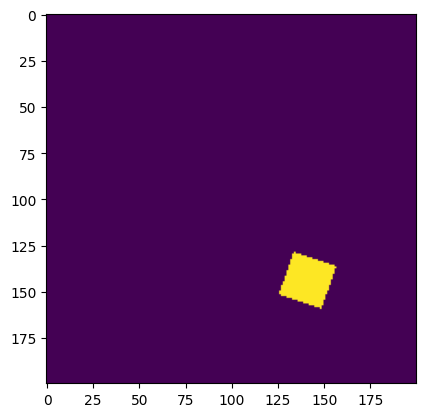

In [4]:
out = detection.draw_lines(img, lines)
main.plt.imshow(out)

# Test Edge Detection on Shapes

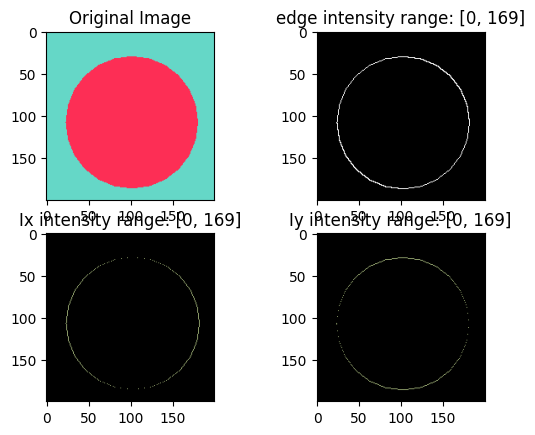

In [5]:
edges, Ix, Iy = pp.gradient(img_BGR, derv_len=1, use_sobel=False)

def show_edge_results(img, edges, Ix, Iy):

    def get_minmax(img):
        min = np.min(img)
        max = np.max(img)
        return min, max

    fig, ax = main.plt.subplots(2,2)
    ax[0,0].title.set_text("Original Image")
    ax[0,0].imshow(img)

    min, max = get_minmax(edges)
    ax[0,1].title.set_text(f"edge intensity range: [{min}, {max}]")
    ax[0,1].imshow(edges, cmap='gray', vmin=min, vmax=max)

    min, max = get_minmax(Ix)
    ax[1,0].title.set_text(f"Ix intensity range: [{min}, {max}]")
    ax[1,0].imshow(Ix, vmin=min, vmax=max)

    min, max = get_minmax(Iy)
    ax[1,1].title.set_text(f"Iy intensity range: [{min}, {max}]")
    ax[1,1].imshow(Iy, vmin=min, vmax=max)

show_edge_results(img_BGR, edges, Ix, Iy)

# Test Edge Detection on Physical Parts

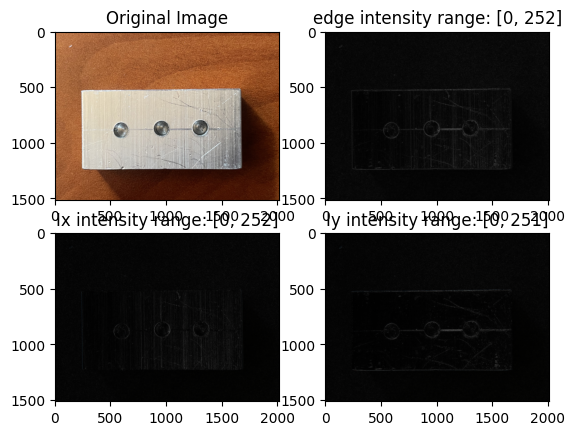

In [6]:
img_path = os.path.join(base_path, "data", "physical parts", "Basic II base part.jpg")

img_part1 = pp.crop(main.load_img(img_path, greyscale=False))

edges, Ix, Iy = pp.gradient(img_part1, derv_len=1, use_sobel=False)

show_edge_results(img_part1, edges, Ix, Iy)

# Test edge detection with denoising

Main Idea:
1. Take simple gradient of original image to get *fine edges*, which will have noisy details

2. Blur original image and take gradient of blurred image to get *rough edges*, which will inflate obvious edges and filter out noisy details

3. Use the *rough edges* as a mask to extract wanted details from *fine edges* to get *masked fine edges*, which should contain only details near wanted edges

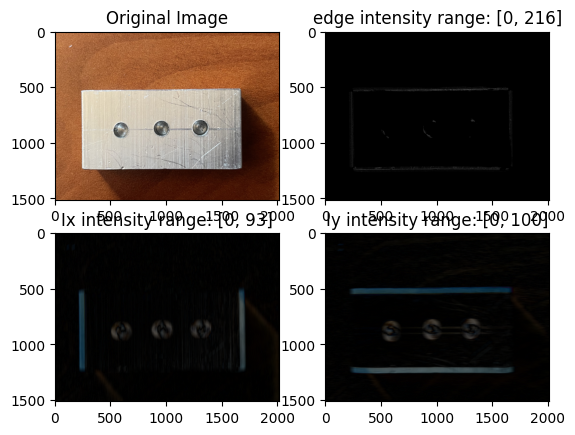

In [7]:
edges_masked, Ix, Iy = pp.getEdgesMasked(img_part1)

show_edge_results(img_part1, edges_masked, Ix, Iy)


# Run Hough Transform

TODO: Canny may not be necessary with our own edge detector

### A1: original -> Canny -> edges

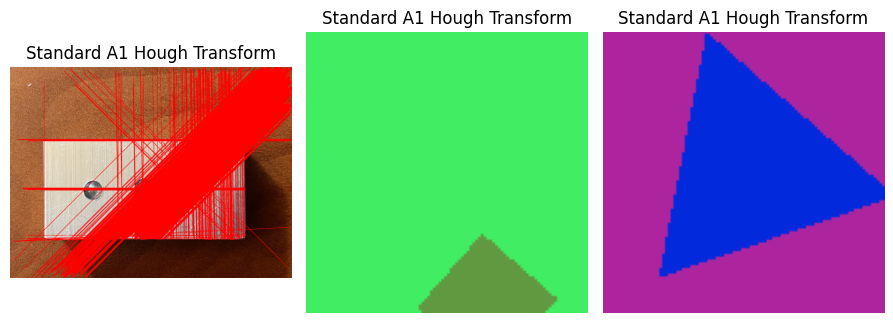

In [8]:

detection.subsample_technique(detection.DETECTION.LINE, "Standard A1 Hough Transform", lambda img: detection.applyHoughTransform(pp.crop(img)))

### A2: original -> Blur -> grad -> Threshold -> Canny -> edges

### A3: 
original -> grad ------------------> mask -> edges  
original -> blur -> grad -> thrs ->

In [9]:
# houghOutput = applyHoughTransform(edges_masked)
# showImage(houghOutput)

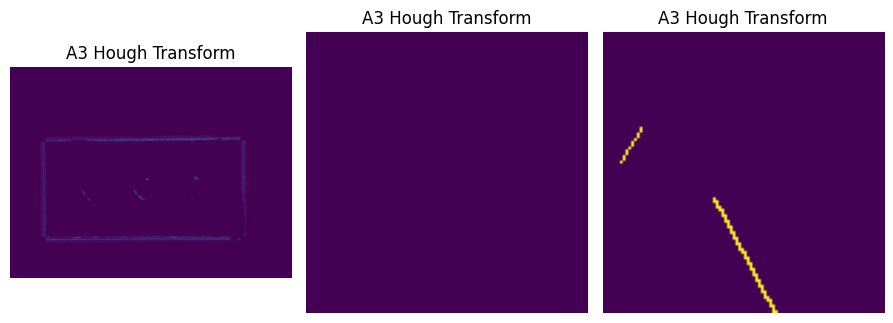

found 0 lines
found 0 lines


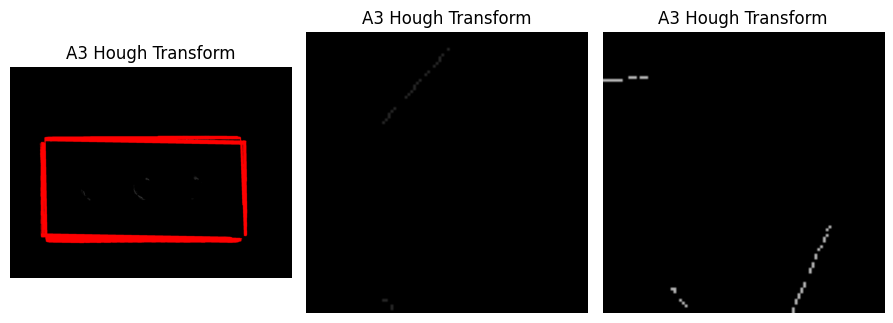

In [10]:
# APPROACH 3: first: org + FT + FLP -> LPF edges; then: LPF edge + Canny + HT
detection.subsample_technique(detection.DETECTION.LINE, "A3 Hough Transform", lambda img: pp.getEdgesMasked(pp.crop(img))[0])
detection.subsample_technique(detection.DETECTION.LINE, "A3 Hough Transform", lambda img: detection.find_lines(pp.getEdgesMasked(pp.crop(img))[0]))


### A4:
original -> grad ------------------> mask -> Canny -> edges  
original -> blur -> grad -> thrs ->


found 0 lines
found 0 lines


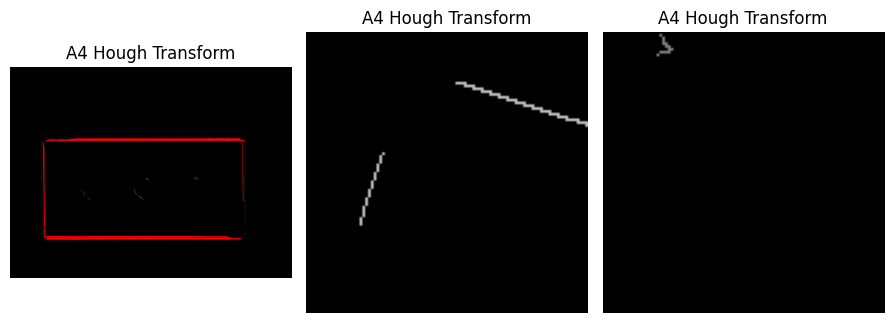

In [11]:
detection.subsample_technique(detection.DETECTION.LINE, "A4 Hough Transform", lambda img: detection.find_lines(pp.getEdgesMasked(pp.crop(img))[0], canny=True))

### General Insights in using HoughLinesP:
* Set maxLineGap to a large number to pick up long & continuous single lines
* Increase threshold to filter out short noisy lines
* Try not to set minLineLength too high, or actual features that are a bit short might be falsely ignored

### A5: original -> grad -> Canny -> edges

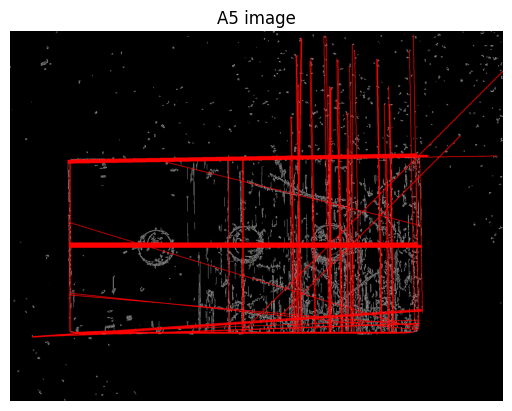

In [12]:
grad, _, _ = pp.gradient(img_part1)
# showImage(grad)
edges = cv2.Canny(grad, 50, 150)
# showImage(edges)

found_lines_A5 = detection.find_lines(edges)
detection.display_single_image(found_lines_A5, "A5 image")

Blur difference mean: 10.39409394158898
Blur difference mean: 0.1575
Blur difference mean: 0.0837
Blur difference mean: 0.2052


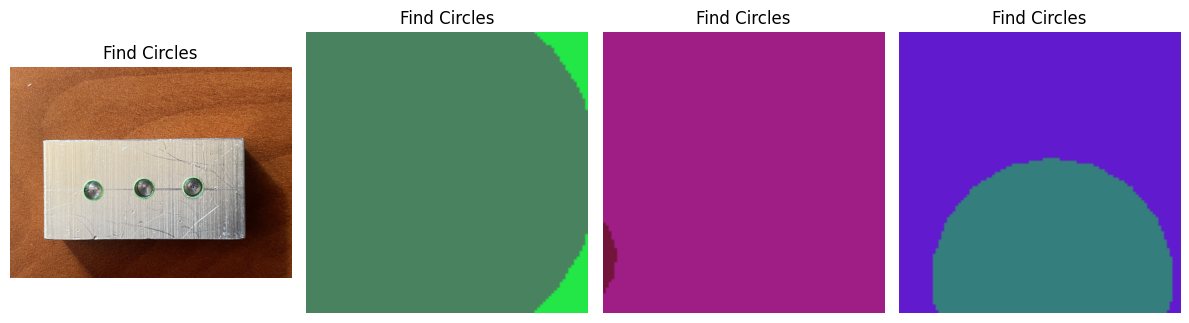

In [13]:


detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circles", lambda img: detection.find_circles(pp.crop(img), blur=True, thresh=60))


found 90 circles
found 0 circles
found 0 circles
found 0 circles


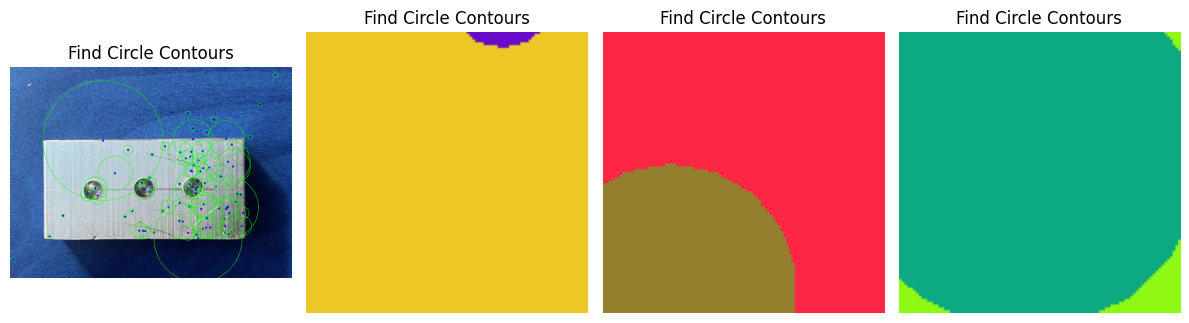

In [14]:

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle Contours", lambda img: detection.find_circles_contours(pp.crop(img), filter=60))


found 301 circles
found 1 circles
found 0 circles
found 0 circles


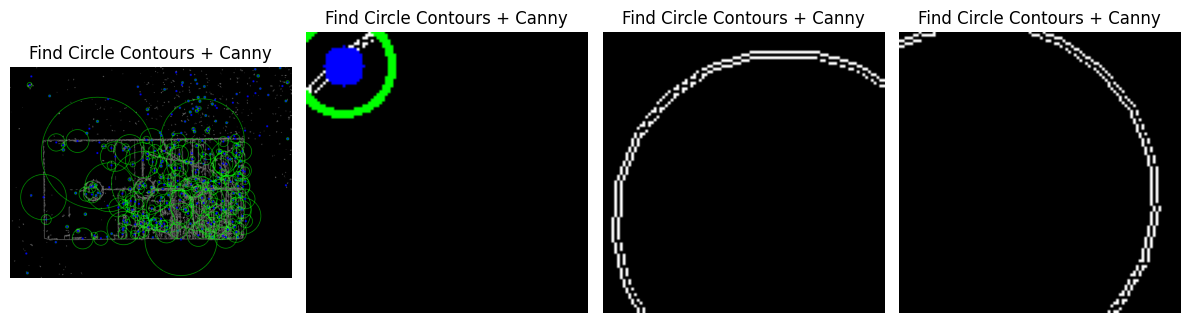

In [15]:
# grad, _, _ = pp.gradient(img_part1)
# # showImage(grad)
# edges = cv2.Canny(grad, 50, 150)
# # showImage(edges)

# found_circles_CT = find_circles_contours(edges, filter=60)
# showImage(found_circles_CT)

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle Contours + Canny", lambda img: detection.find_circles_contours(cv2.Canny(pp.gradient(pp.crop(img))[0], 50, 150), filter=60))


# Ransac Circle Detection

Not enough edge points


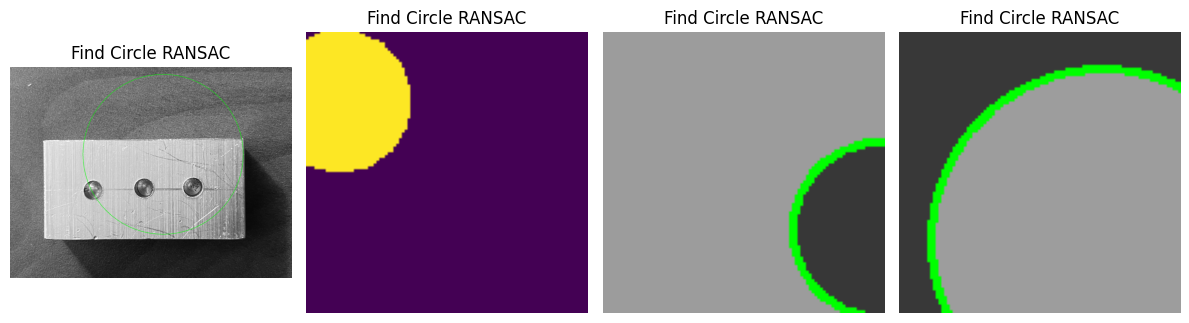

In [16]:

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle RANSAC", lambda img: detection.find_circle_ransac(pp.crop(img)))


In [ ]:
from features import Line, Circle
import numpy as np

# synthetic edge points (x,y)
edge_points = np.array([
    [10,10], [11,10], [12,10], [50,50], [100,100],
    [30,31], [31,30], [28,29], [60,60]
])

# line from (10,10) to (12,10)
ln = Line((10,10,12,10), max_perp_dist=1.0, require_on_segment=True)
matched_pts, matched_idx = ln.match_pts(edge_points)
print('Line matched count:', len(matched_idx), 'pts:', matched_pts)

# circle centered at (30,30) radius 2: should match (30,31),(31,30),(28,29)
c = Circle((30,30,2.0), max_rad_diff=1.5)
c_matched, c_idx = c.match_pts(edge_points)
print('Circle matched count:', len(c_idx), 'pts:', c_matched)


Line matched count: 3 pts: [[10 10]
 [11 10]
 [12 10]]
Circle matched count: 3 pts: [[30 31]
 [31 30]
 [28 29]]
Circle matched with bigger tol: 3 pts: [[30 31]
 [31 30]
 [28 29]]


In [ ]:
import importlib
import features
importlib.reload(features)
from features import match_points_to_lines, match_points_to_circles, visualize_matches

# derive edge_points from the masked edges produced earlier
edges_masked = pp.getEdgesMasked(img_part1)[0]
ys, xs = np.nonzero(edges_masked)
edge_points = np.column_stack((xs, ys))
print('edge_points count:', edge_points.shape[0])

# Match and visualize lines (use detect_line which returns tuples)
try:
    found_lines = detection.detect_line(img_part1, canny_thres1=50, canny_thres2=150, rho=1, theta=np.pi/180, hough_thres=80, min_line_len=10, max_line_gap=10)
    line_features = match_points_to_lines(found_lines, edge_points, max_perp_dist=3.0)
    print('Found lines:', len(found_lines), 'Matched features:', len(line_features))
    for i, f in enumerate(line_features):
        print(f'Line {i}: matched pts = {len(f.pts)}')
    visualize_matches(img_part1, line_features, title='Line matches')
except Exception as e:
    print('Line detection/visualization failed:', e)

# Match and visualize circles: run HoughCircles to get parameters
try:
    img_for_circles = pp.crop(img_part1)
    gray = cv2.cvtColor(img_for_circles, cv2.COLOR_BGR2GRAY) if img_for_circles.ndim==3 else img_for_circles
    before = gray.copy()
    gray_blur = cv2.medianBlur(gray, 17)
    diff = cv2.absdiff(before, gray_blur)
    print('Blur difference mean:', diff.mean())
    circles_raw = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=100, param2=60, minRadius=5, maxRadius=0)
    if circles_raw is not None:
        circles = np.round(circles_raw[0, :]).astype(int)
        found_circles = [tuple(c) for c in circles]
    else:
        found_circles = []
    circ_features = match_points_to_circles(found_circles, edge_points, max_rad_diff=4.0)
    print('Found circles:', len(found_circles), 'Matched features:', len(circ_features))
    for i, f in enumerate(circ_features):
        print(f'Circle {i}: matched pts = {len(f.pts)}')
    visualize_matches(img_part1, circ_features, title='Circle matches')
except Exception as e:
    print('Circle detection/visualization failed:', e)


edge_points count: 156766
Line detection/visualization failed: only length-1 arrays can be converted to Python scalars
Blur difference mean: 13.912808641975309
Circle detection/visualization failed: only length-1 arrays can be converted to Python scalars
